<!-- dom:TITLE: Data Analysis and Machine Learning: Getting started, our first data and Machine Learning encounters -->
# Esempi di regressione lineare 
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
<!-- dom:AUTHOR: Carlo Barbieri at Department of Physics, Università Statale di Milano -->
<!-- Author: -->  
Note adattate dal corso di  **Morten Hjorth-Jensen**, Dipartimento di fisica (Università di Oslo e Michigan State University).

C. Barbieri, $\qquad$ **Novembre 2020**.


Qui di segtuito sono riportate applicazioni a tre problemi (due in fisica  nucleare ed un terzo nell'analisi del mercato immobiliare) usando regressione lineare e studiano le correlazioni tra predittori.

I primi due esempi introducono una tecnica ed un concetto importanti:

+ Si danno due esempi di come leggere set di dati da un file (in formato di test *.txt* oppure *.cvs', in questo notebook) creandone dei *DataFrame* di **Pandas**.

+ Concettualmente molto importante, gli esempi dimostrano come si possa utilizzare un set appropriato di funzionfi di base per trasformalre la regressione lineare in un modello non-lineare e più manleabile. Nel caso specifico si usa un set di potenze per ottenere un modello polinomiale: sebbene la caratteristica (o predittore) in ingresso sia una variabile sola (la massa nuclear o la densità) si può ottenere un comportamento non lineare espandendo su più predittori 'fittizi' che dipendono dalla stessa variabile.

Il terzo esempio va più a fondo nel dimostrare l'uso di *Pandas* e *Seaborn* per generare matricici covarianza e produrre grafici utili nell'investigare correlazioni tra i predittori.

---
# Formula semiempirica per le masse nucleari proposta da Weizsäcker

Let us now dive into  nuclear physics and remind ourselves briefly about some basic features about binding
energies.  A basic quantity which can be measured for the ground
states of nuclei is the atomic mass $M(N, Z)$ of the neutral atom with
atomic mass number $A$ and charge $Z$. The number of neutrons is $N$. There are indeed several sophisticated experiments worldwide which allow us to measure this quantity to high precision (parts per million even). 

Atomic masses are usually tabulated in terms of the mass excess defined by

$$
\Delta M(N, Z) =  M(N, Z) - uA,
$$

where $u$ is the Atomic Mass Unit

$$
u = M(^{12}\mathrm{C})/12 = 931.4940954(57) \hspace{0.1cm} \mathrm{MeV}/c^2.
$$

The nucleon masses are

$$
m_p =  1.00727646693(9)u,
$$

and

$$
m_n = 939.56536(8)\hspace{0.1cm} \mathrm{MeV}/c^2 = 1.0086649156(6)u.
$$

In the [2016 mass evaluation of by W.J.Huang, G.Audi, M.Wang, F.G.Kondev, S.Naimi and X.Xu](http://nuclearmasses.org/resources_folder/Wang_2017_Chinese_Phys_C_41_030003.pdf)
there are data on masses and decays of 3437 nuclei.

The nuclear binding energy is defined as the energy required to break
up a given nucleus into its constituent parts of $N$ neutrons and $Z$
protons. In terms of the atomic masses $M(N, Z)$ the binding energy is
defined by

$$
BE(N, Z) = ZM_H c^2 + Nm_n c^2 - M(N, Z)c^2 ,
$$

where $M_H$ is the mass of the hydrogen atom and $m_n$ is the mass of the neutron.
In terms of the mass excess the binding energy is given by

$$
BE(N, Z) = Z\Delta_H c^2 + N\Delta_n c^2 -\Delta(N, Z)c^2 ,
$$

where $\Delta_H c^2 = 7.2890$ MeV and $\Delta_n c^2 = 8.0713$ MeV.


A popular and physically intuitive model which can be used to parametrize 
the experimental binding energies as function of $A$, is the so-called 
**liquid drop model**. The ansatz is based on the following expression

$$
BE(N,Z) = a_1A-a_2A^{2/3}-a_3\frac{Z^2}{A^{1/3}}-a_4\frac{(N-Z)^2}{A},
$$

where $A$ stands for the number of nucleons and the $a_i$s are parameters which are determined by a fit 
to the experimental data.  




To arrive at the above expression we have assumed that we can make the following assumptions:

 * There is a volume term $a_1A$ proportional with the number of nucleons (the energy is also an extensive quantity). When an assembly of nucleons of the same size is packed together into the smallest volume, each interior nucleon has a certain number of other nucleons in contact with it. This contribution is proportional to the volume.

 * There is a surface energy term $a_2A^{2/3}$. The assumption here is that a nucleon at the surface of a nucleus interacts with fewer other nucleons than one in the interior of the nucleus and hence its binding energy is less. This surface energy term takes that into account and is therefore negative and is proportional to the surface area.

 * There is a Coulomb energy term $a_3\frac{Z^2}{A^{1/3}}$. The electric repulsion between each pair of protons in a nucleus yields less binding. 

 * There is an asymmetry term $a_4\frac{(N-Z)^2}{A}$. This term is associated with the Pauli exclusion principle and reflects the fact that the proton-neutron interaction is more attractive on the average than the neutron-neutron and proton-proton interactions.

We could also add a so-called pairing term, which is a correction term that
arises from the tendency of proton pairs and neutron pairs to
occur. An even number of particles is more stable than an odd number. 


### Organizing our data

Let us start with reading and organizing our data. 
We start with the compilation of masses and binding energies from 2016.
After having downloaded this file to our own computer, we are now ready to read the file and start structuring our data.


We start with preparing folders for storing our calculations and the data file over masses and binding energies. We import also various modules that we will find useful in order to present various Machine Learning methods. Here we focus mainly on the functionality of **scikit-learn**.

In [13]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

Before we proceed, we define also a function for making our plots. You can obviously avoid this and simply set up various **matplotlib** commands every time you need them. You may however find it convenient to collect all such commands in one function and simply call this function.

In [14]:
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

Our next step is to read the data on experimental binding energies and
reorganize them as functions of the mass number $A$, the number of
protons $Z$ and neutrons $N$ using **pandas**.  Before we do this it is
always useful (unless you have a binary file or other types of compressed
data) to actually open the file and simply take a look at it!


In particular, the program that outputs the final nuclear masses is written in Fortran with a specific format. It means that we need to figure out the format and which columns contain the data we are interested in. Pandas comes with a function that reads formatted output. After having admired the file, we are now ready to start massaging it with **pandas**. The file begins with some basic format information.

In [ ]:
""""                                                                                                                     
This is taken from the data file of the mass 2016 evaluation.                                                               
All files are 3436 lines long with 124 character per line.                                                                  
       Headers are 39 lines long.                                                                                           
   col 1     :  Fortran character control: 1 = page feed  0 = line feed                                                     
   format    :  a1,i3,i5,i5,i5,1x,a3,a4,1x,f13.5,f11.5,f11.3,f9.3,1x,a2,f11.3,f9.3,1x,i3,1x,f12.5,f11.5                     
   These formats are reflected in the pandas widths variable below, see the statement                                       
   widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),                                                            
   Pandas has also a variable header, with length 39 in this case.                                                          
"""

The data we are interested in are in columns 2, 3, 4 and 11, giving us
the number of neutrons, protons, mass numbers and binding energies,
respectively. We add also for the sake of completeness the element name. The data are in fixed-width formatted lines and we will
covert them into the **pandas** DataFrame structure.

In [15]:
# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

We have now read in the data, grouped them according to the variables we are interested in. 
We see how easy it is to reorganize the data using **pandas**. If we
were to do these operations in C/C++ or Fortran, we would have had to
write various functions/subroutines which perform the above
reorganizations for us.  Having reorganized the data, we can now start
to make some simple fits using both the functionalities in **numpy** and
**Scikit-Learn** afterwards. 

Now we define five variables which contain
the number of nucleons $A$, the number of protons $Z$ and the number of neutrons $N$, the element name and finally the energies themselves.

In [16]:
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']
print(Masses)


            N    Z    A Element  Ebinding
A                                        
4   0       1    3    4      Li  1.153760
5   2       3    2    5      He  5.512132
6   7       3    3    6      Li  5.332331
7   12      4    3    7      Li  5.606439
8   17      4    4    8      Be  7.062435
...       ...  ...  ...     ...       ...
264 3297  156  108  264      Hs  7.298375
265 3303  157  108  265      Hs  7.296247
266 3310  158  108  266      Hs  7.298273
269 3331  159  110  269      Ds  7.250154
270 3337  160  110  270      Ds  7.253775

[264 rows x 5 columns]


The next step, and we will define this mathematically later, is to set up the so-called **design matrix**. We will throughout call this matrix $\boldsymbol{X}$.
It has dimensionality $p\times n$, where $n$ is the number of data points and $p$ are the so-called predictors. In our case here they are given by the number of polynomials in $A$ we wish to include in the fit.

Per semplicità, useremo la seguente formula esprtessione della formula delle masse (ovvero trascurando la possibile dipendenza $Z$ ed $N-Z$):

$$
BE(A) = a_0+a_1A+a_2A^{2/3}+a_3A^{-1/3}+a_4A^{-1},
$$

per questo motivo abbiamo selezionato un isotopo per ogni valore di $A$.

Nel creare la matrice di design abbiamo per ogni dato: $\boldsymbol{x}_i=[x_{i0},x_{i1},\dots,x_{i4}] = [1, A_i, A_i^{2/3}, A_i^{-1/3}, A_i^{-1}]$,

mentre i parametri del modellso sono $\boldsymbol{\beta}_i=[\beta_{i0},\beta_{i1},\dots,\beta_{i4}]\equiv[a_{i0},a_{i1},\dots,a_{i4}]$. 


Il modello di regressione lineare è

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta}+\boldsymbol{\epsilon},
$$

dove $\boldsymbol{\epsilon}$ rappresente un errore aleatorio. Esplicitando la metrice abbiamo $p=5$ colonne per i parametri e $n=267$ righe per i dati:

$$
\begin{align*}
y_0&=\beta_0x_{00}+\beta_1x_{01}+\beta_2x_{02}+\dots+\beta_{n-1}x_{0p-1}+\epsilon_0\\
y_1&=\beta_0x_{10}+\beta_1x_{11}+\beta_2x_{12}+\dots+\beta_{n-1}x_{1p-1}+\epsilon_1\\
y_2&=\beta_0x_{20}+\beta_1x_{21}+\beta_2x_{22}+\dots+\beta_{n-1}x_{2p-1}+\epsilon_2\\
\dots & \dots \\
y_{i}&=\beta_0x_{i0}+\beta_1x_{i1}+\beta_2x_{i2}+\dots+\beta_{n-1}x_{ip-1}+\epsilon_i\\
\dots & \dots \\
y_{n-1}&=\beta_0x_{n-1,0}+\beta_1x_{n-1,2}+\beta_2x_{n-1,2}+\dots+\beta_{n-1}x_{n-1,p-1}+\epsilon_{n-1}.\\
\end{align*}
$$


Cerchiamo la solusione di

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta},
$$

invertendo la matrice $\boldsymbol{X}^T\boldsymbol{X}$  e ottenendo:

$$
\boldsymbol{\beta} =\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}.
$$

In [17]:
# Now we set up the design matrix X
X = np.zeros((len(A),5))
X[:,0] = 1
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = A**(-1.0/3.0)
X[:,4] = A**(-1.0)
# Then nice printout using pandas
DesignMatrix = pd.DataFrame(X)
DesignMatrix.index = A
DesignMatrix.columns = ['1', 'A', 'A^(2/3)', 'A^(-1/3)', '1/A']
display(DesignMatrix)

1      A    A^(2/3)  A^(-1/3)       1/A
A                                             
4    1.0    4.0   2.519842  0.629961  0.250000
5    1.0    5.0   2.924018  0.584804  0.200000
6    1.0    6.0   3.301927  0.550321  0.166667
7    1.0    7.0   3.659306  0.522758  0.142857
8    1.0    8.0   4.000000  0.500000  0.125000
..   ...    ...        ...       ...       ...
264  1.0  264.0  41.153106  0.155883  0.003788
265  1.0  265.0  41.256962  0.155687  0.003774
266  1.0  266.0  41.360688  0.155491  0.003759
269  1.0  269.0  41.671089  0.154911  0.003717
270  1.0  270.0  41.774300  0.154720  0.003704

[264 rows x 5 columns]

With **scikitlearn** we are now ready to use linear regression and fit our data.

In [18]:
clf = skl.LinearRegression().fit(X, Energies)
fity = clf.predict(X)

Pretty simple!  
Now we can print measures of how our fit is doing, the coefficients from the fits and plot the final fit together with our data.

Mean squared error: 0.02
Variance score: 0.95
Mean absolute error: 0.05
[ 0.00000000e+00 -2.96611194e-02  2.01719003e-01  1.08078025e+01
 -4.03097597e+01] 5.294399745619694


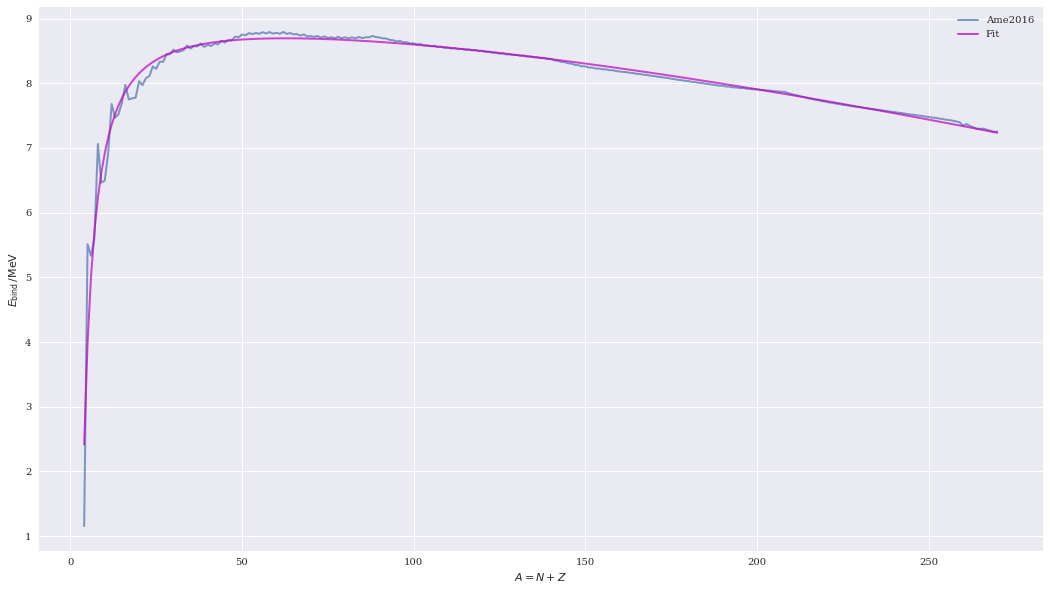

In [19]:
# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(Energies, fity))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(Energies, fity))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(Energies, fity))
print(clf.coef_, clf.intercept_)

Masses['Eapprox']  = fity
# Generate a plot comparing the experimental with the fitted values values.
fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], alpha=0.7, lw=2,
            label='Ame2016')
ax.plot(Masses['A'], Masses['Eapprox'], alpha=0.7, lw=2, c='m',
            label='Fit')
ax.legend()
save_fig("Masses2016")
plt.show()


# Fitting an Equation of State for Dense Nuclear Matter

Before we continue, let us introduce yet another example. We are going to fit the
nuclear equation of state using results from many-body calculations.
The equation of state we have made available here, as function of
density, has been derived using modern nucleon-nucleon potentials with
[the addition of three-body
forces](https://www.sciencedirect.com/science/article/pii/S0370157399001106). This
time the file is presented as a standard **csv** file.

The beginning of the Python code here is similar to what you have seen
before, with the same initializations and declarations. We use also
**pandas** again, rather extensively in order to organize our data.

The difference now is that we use **Scikit-Learn's** regression tools
instead of our own matrix inversion implementation. Furthermore, we
sneak in **Ridge** regression (introdotta nella lezione precendente) which includes a
hyperparameter $\lambda$, also to be explained below.


In  questo caso useremo il seguente modello per l'equazione di stato:
$
E[\rho]= \beta_0 + \beta_1 \rho^{2/3} + \beta_2 \rho + \beta_3 \rho^{4/3} \, .
$

## The code

Mean squared error: 12.36
Variance score: 1.00
Mean absolute error: 2.83
[   0.          618.32047562 -861.13519106 1404.91549644] -11.057088709963068
Mean squared error: 197.93
Variance score: 1.00
Mean absolute error: 11.69
[  0.          28.18220995 282.79902342 842.30879705] 12.946893955213227


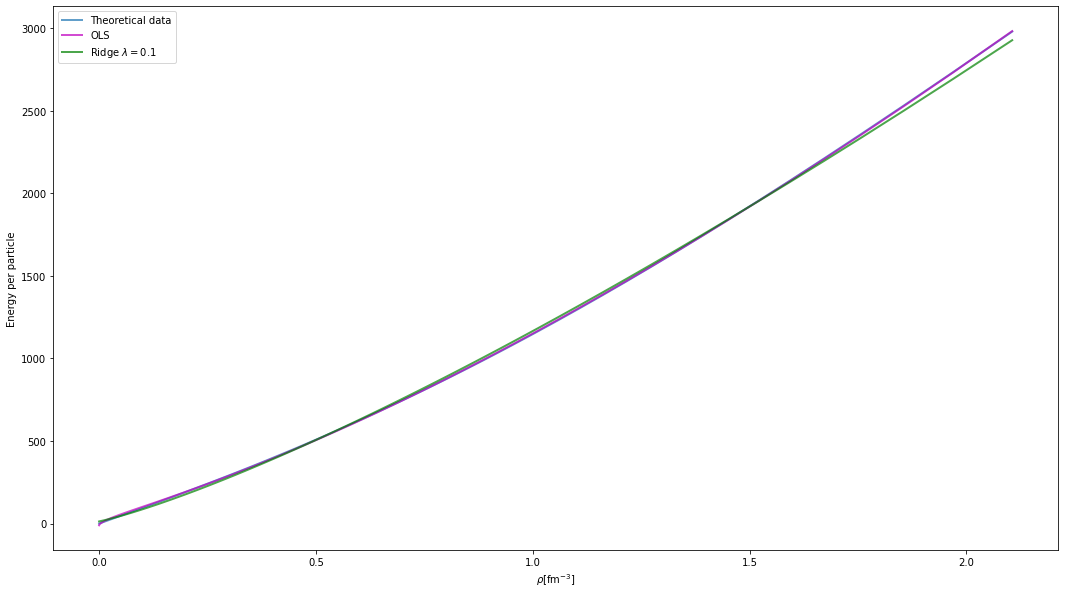

In [2]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("EoS.csv"),'r')

# Read the EoS data as  csv file and organize the data into two arrays with density and energies
EoS = pd.read_csv(infile, names=('Density', 'Energy'))
EoS['Energy'] = pd.to_numeric(EoS['Energy'], errors='coerce')
EoS = EoS.dropna()
Energies = EoS['Energy']
Density = EoS['Density']
#  The design matrix now as function of various polytrops
X = np.zeros((len(Density),4))
X[:,3] = Density**(4.0/3.0)
X[:,2] = Density
X[:,1] = Density**(2.0/3.0)
X[:,0] = 1

# We use now Scikit-Learn's linear regressor and ridge regressor
# OLS part
clf = skl.LinearRegression().fit(X, Energies)
ytilde = clf.predict(X)
EoS['Eols']  = ytilde
# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(Energies, ytilde))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(Energies, ytilde))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(Energies, ytilde))
print(clf.coef_, clf.intercept_)

# The Ridge regression with a hyperparameter lambda = 0.1
_lambda = 0.1
clf_ridge = skl.Ridge(alpha=_lambda).fit(X, Energies)
yridge = clf_ridge.predict(X)
EoS['Eridge']  = yridge
# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(Energies, yridge))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(Energies, yridge))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(Energies, yridge))
print(clf_ridge.coef_, clf_ridge.intercept_)

fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel(r'$\rho[\mathrm{fm}^{-3}]$')
ax.set_ylabel(r'Energy per particle')
ax.plot(EoS['Density'], EoS['Energy'], alpha=0.7, lw=2,
            label='Theoretical data')
ax.plot(EoS['Density'], EoS['Eols'], alpha=0.7, lw=2, c='m',
            label='OLS')
ax.plot(EoS['Density'], EoS['Eridge'], alpha=0.7, lw=2, c='g',
            label='Ridge $\lambda = 0.1$')
ax.legend()
save_fig("EoSfitting")
plt.show()

The above simple polynomial in density $\rho$ gives an excellent fit
to the data. 

We note also that there is a small deviation between the
standard OLS and the Ridge regression at higher densities. We discuss this in more detail
below.


## Splitting our Data in Training and Test data

It is normal in essentially all Machine Learning studies to split the
data in a training set and a test set (sometimes also an additional
validation set).  **Scikit-Learn** has an own function for this. There
is no explicit recipe for how much data should be included as training
data and say test data.  An accepted rule of thumb is to use
approximately $2/3$ to $4/5$ of the data as training data. We will
postpone a discussion of this splitting to the end of these notes and
our discussion of the so-called **bias-variance** tradeoff. Here we
limit ourselves to repeat the above equation of state fitting example
but now splitting the data into a training set and a test set.

In  questo caso useremo il seguente modello per l'equazione di stato:

$$
E[\rho]= \beta_0 + \beta_1 \rho^{2/3} + \beta_2 \rho + \beta_3 \rho^{4/3} + \beta_4 \rho^{5/3} \, .
$$

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

infile = open(data_path("EoS.csv"),'r')

# Read the EoS data as  csv file and organized into two arrays with density and energies
EoS = pd.read_csv(infile, names=('Density', 'Energy'))
EoS['Energy'] = pd.to_numeric(EoS['Energy'], errors='coerce')
EoS = EoS.dropna()
Energies = EoS['Energy']
Density = EoS['Density']
#  The design matrix now as function of various polytrops
X = np.zeros((len(Density),5))
X[:,0] = 1
X[:,1] = Density**(2.0/3.0)
X[:,2] = Density
X[:,3] = Density**(4.0/3.0)
X[:,4] = Density**(5.0/3.0)
# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, Energies, test_size=0.2)
# matrix inversion to find beta
beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
# and then make the prediction
ytilde = X_train @ beta
print("Training R2")
print(R2(y_train,ytilde))
print("Training MSE")
print(MSE(y_train,ytilde))
ypredict = X_test @ beta
print("Test R2")
print(R2(y_test,ypredict))
print("Test MSE")
print(MSE(y_test,ypredict))

Training R2
0.9999866293684156
Training MSE
6.567510462476487
Test R2
0.9999786165752792
Test MSE
5.509468663246434


<!-- !split  -->
#The Boston housing data example

The Boston housing data set was originally a part of UCI Machine Learning Repository
and has been removed now. The data set is now included in **Scikit-Learn**'s 
library.  There are 506 samples and 13 feature (predictor) variables
in this data set. The objective is to predict the value of prices of
the house using the features (predictors) listed here.

The features/predictors are
1. CRIM: Per capita crime rate by town

2. ZN: Proportion of residential land zoned for lots over 25000 square feet

3. INDUS: Proportion of non-retail business acres per town

4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

5. NOX: Nitric oxide concentration (parts per 10 million)

6. RM: Average number of rooms per dwelling

7. AGE: Proportion of owner-occupied units built prior to 1940

8. DIS: Weighted distances to five Boston employment centers

9. RAD: Index of accessibility to radial highways

10. TAX: Full-value property tax rate per USD10000

11. B: $1000(Bk - 0.63)^2$, where $Bk$ is the proportion of [people of African American descent] by town

12. LSTAT: Percentage of lower status of the population

13. MEDV: Median value of owner-occupied homes in USD 1000s

## Housing data, the code
We start by importing the libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns

and load the Boston Housing DataSet from **Scikit-Learn**

In [5]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()

# boston_dataset is a dictionary
# let's check what it contains
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Then we invoke Pandas

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()
boston['MEDV'] = boston_dataset.target

and preprocess the data

In [7]:
# check for missing values in all the columns
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

We can then visualize the data

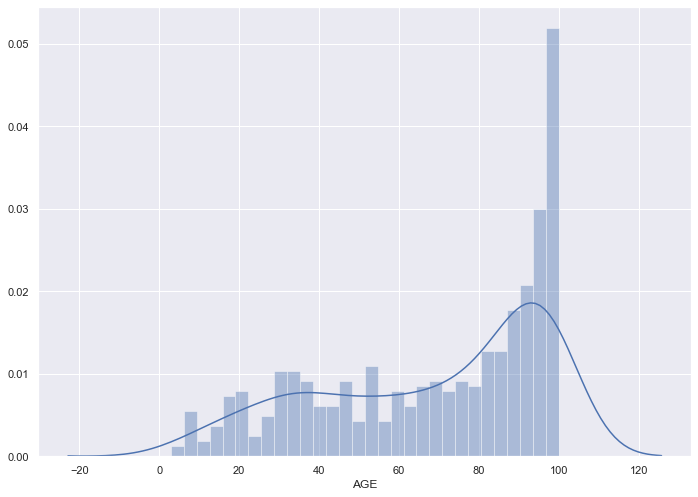

In [8]:
# set the size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# plot a histogram showing the distribution of the target values
sns.distplot(boston['AGE'], bins=30)
plt.show()

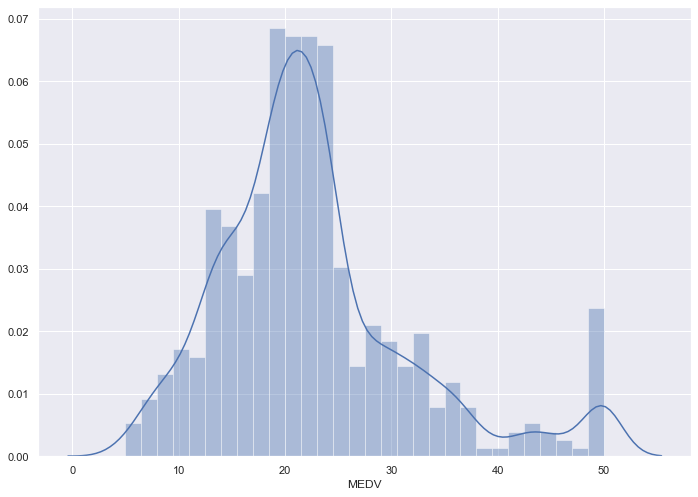

In [42]:
# set the size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# plot a histogram showing the distribution of the target values
sns.distplot(boston['MEDV'], bins=30)
plt.show()

It is now useful to look at the correlation matrix

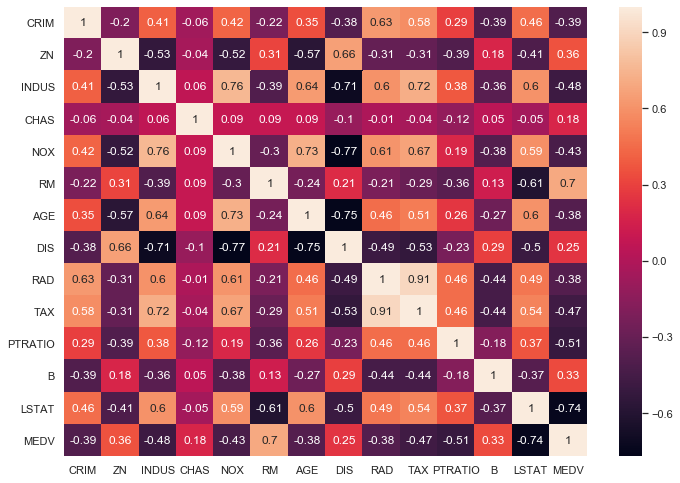

In [9]:
# compute the pair wise correlation for all columns  
correlation_matrix = boston.corr().round(2)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

From the above coorelation plot we can see that **MEDV** is strongly correlated to **LSTAT** and  **RM**. We see also that **RAD** and **TAX** are stronly correlated, but we don't include this in our features together to avoid multi-colinearity

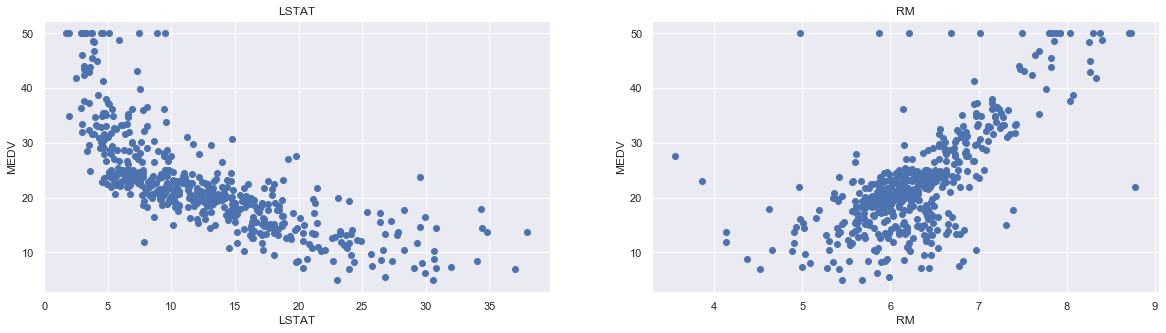

In [10]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

Now we start training our model

In [11]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']

We split the data into training and test sets

In [12]:
from sklearn.model_selection import train_test_split

# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


Then we use the linear regression functionality from **Scikit-Learn**

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

# model evaluation for training set

y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5.6371293350711955
R2 score is 0.6300745149331701


The model performance for testing set
--------------------------------------
RMSE is 5.13740078470291
R2 score is 0.6628996975186954


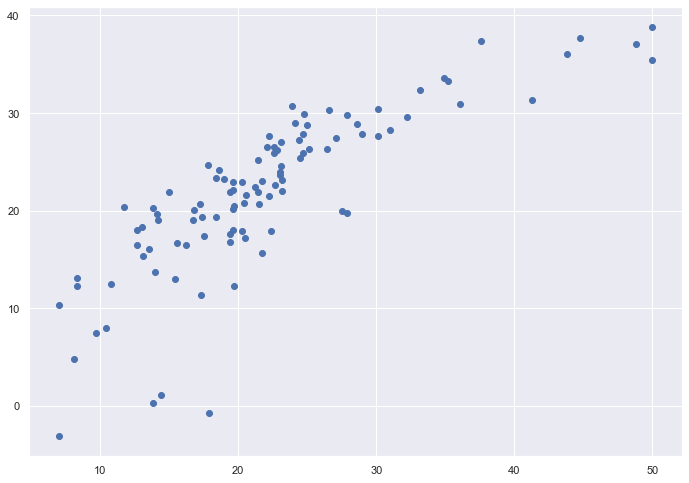

In [14]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(Y_test, y_test_predict)
plt.show()